In [1]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, sqlite3, pickle, time, datetime, random, os
from dateutil.relativedelta import relativedelta

pd.options.display.float_format = '{:,.4f}'.format

# Load Processed parameters and data

In [2]:
##############################################################################
#######################################
### Relevant fields for pre-processing
#######################################
reference_date = datetime.datetime(1970,1,1)

##### Fields in table patients ##########
patient_field         = 'patient_id'
age_field             = 'age_at_admission\r'
sex_field             = 'sex'
ethnic_field          = 'ethnic_origin'
death_ind_field       = 'death_indicator'
death_date_field      = 'date_of_death'
death_date_code_field = 'date_code_of_death'
mort_in_hosp_field    = 'Thirty_day_mort'

##### Fields in table admissions ########
admission_field           = 'admission_id'
diagnosis_field           = 'episode_diagnoses'
admn_date_field           = 'admission_date_time'
admn_discharge_field      = 'discharge_date_time'
admn_date_code_field      = 'admission_date_code_time'
admn_discharge_code_field = 'discharge_date_code_time'
lengthofstay_field        = 'lengthofstay'
isPneumonia_field         = 'isPneumonia'
mortal_admin_field        = 'mortal_admin'
comorbidity_field         = 'Comorbidity_score'
icu_admin_field           = 'icu_count\r'
no_eobs_field             = 'no_obs_eobs'
no_haematology_field      = 'no_haematology_eobs'
meds_drug_field           = 'Drug_supplied'
specific_comorb_field     = 'Specific Comorbidity'
prev_admin_field          = 'had_Prev_admin'
has_spin_field            = 'adm_has_spin'
cubr65_field              = 'CURB65'
antibiot_4h_field         = 'antibiotic_4h'

 ##### Fields in table eObservations #####
eObs_time_field      = 'timestamp'
eObs_time_code_field = 'timestamp_code'
eObs_time_prev_obs   = 'time_since_prev_obs_in_mins'
eObs_resprate_field  = 'rr'
eObs_sbp_field       = 'sbp'
eObs_dbp_field       = 'dbp'
eObs_newscore_field  = 'ews'
eObs_heartrate_field = 'heart_rate'
eObs_temptr_field    = 'temperature\r'
eObs_oxygen_field    = 'Oxygen_Saturation'


In [3]:
data = pickle.load( open('DataFrame_pickles/df_patients_admissions_2016_18_v4.pickle', 'rb'))
df_patients   = data[0]
df_admissions = data[1]

df_eobs   = pickle.load( open("DataFrame_pickles/df_eobs_3d.pickle", "rb" ))
admn_eobs = df_eobs['admission_id'].unique().tolist()

lst_admn_ = df_admissions[(~df_admissions['CURB65'].isna())]['admission_id']


df_eobs_curb65  = df_eobs[df_eobs['admission_id'].isin(lst_admn_)]
lst_admn_curb65 = df_eobs[df_eobs['admission_id'].isin(lst_admn_)]['admission_id'].unique().tolist()
df_admn_curb65  = df_admissions[df_admissions['admission_id'].isin(lst_admn_curb65)]

print("##########################################################################################")
print("############################### DATA 2016 - 18 ###########################################")
print("##########################################################################################")
print("")
print("Number of admissions in ADMISSIONS with CURB65 data", len(lst_admn_))
print("Number of admissions in EOBS interpolated", len(admn_eobs))
print("Number of admissions in EObs that have CURB65 data", len(lst_admn_curb65))


##########################################################################################
############################### DATA 2016 - 18 ###########################################
##########################################################################################

Number of admissions in ADMISSIONS with CURB65 data 4517
Number of admissions in EOBS interpolated 13950
Number of admissions in EObs that have CURB65 data 3319


In [4]:
df_admn_curb65.columns

Index(['admission_id', 'episode_diagnoses', 'patient_id', 'age_at_admission\r',
       'admission_date_time', 'admission_date_code_time',
       'discharge_date_time', 'discharge_date_code_time', 'lengthofstay',
       'isPneumonia', 'mortal_admin', 'icu_count\r', 'Comorbidity_score',
       'no_obs_eobs', 'no_haematology_eobs', 'receivedMedicines',
       'Specific Comorbidity', 'had_Prev_admin', 'adm_has_spin', 'CURB65',
       'antibiotic_4h'],
      dtype='object')

/local/dlr10/ipykernel_3401/2446453698.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_admn_curb65['CURB_tier'] = df_admn_curb65['CURB65'].apply(lambda x: 0 if x <=1 else 1 if x == 2 else 2)


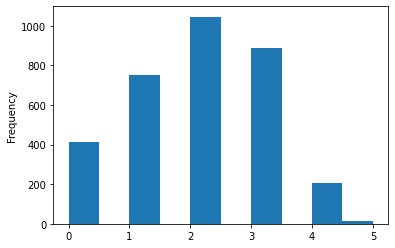

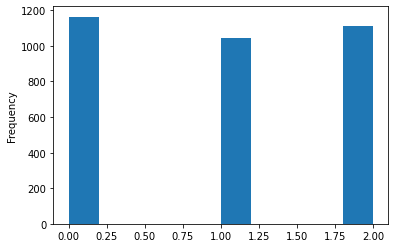

In [5]:
df_admn_curb65['CURB_tier'] = df_admn_curb65['CURB65'].apply(lambda x: 0 if x <=1 else 1 if x == 2 else 2)
df_admn_curb65['CURB65'].plot.hist()
plt.show()
df_admn_curb65['CURB_tier'].plot.hist()
plt.show()

In [6]:
display(df_admn_curb65.head(4))
display(df_eobs_curb65.head(4))

,admission_id,episode_diagnoses,patient_id,age_at_admission\r,admission_date_time,admission_date_code_time,discharge_date_time,discharge_date_code_time,lengthofstay,isPneumonia,...,Comorbidity_score,no_obs_eobs,no_haematology_eobs,receivedMedicines,Specific Comorbidity,had_Prev_admin,adm_has_spin,CURB65,antibiotic_4h,CURB_tier
6,67812046,"||J45.9,J18.9,F17.1||J45.9,J18.9,F17.1",80081107,40,2018-01-05 13:14:00,"17,536.5514",2018-01-09 16:15:00,"17,540.6771",4 days 03:01:00,1,...,0,18,1,1,0,0.0000,1.0000,0.0000,1.0000,0
14,43167535,"||J18.1,A41.9,R65.1,N17.9,N18.9,E11.2 D,N08.3 ...",59390959,89,2018-05-18 00:49:00,"17,669.0340",2018-05-22 19:00:00,"17,673.7917",4 days 18:11:00,1,...,4,17,2,1,1,0.0000,1.0000,3.0000,1.0000,2
15,6483250,"||A41.9,R65.1,J18.9,N17.9,N18.9,E86.X,E11.9,J9...",59390959,89,2018-05-31 11:27:00,"17,682.4771",2018-06-10 17:30:00,"17,692.7292",10 days 06:03:00,1,...,9,52,5,1,1,1.0000,1.0000,3.0000,1.0000,2
16,43986838,"||J18.9,A41.9,N17.9,C34.9,R29.6,F03.X,I10.X,E1...",59390959,89,2018-10-23 01:56:00,"17,827.0806",2018-11-12 18:00:00,"17,847.7500",20 days 16:04:00,1,...,6,83,6,1,1,1.0000,1.0000,4.0000,1.0000,2


,admission_id,timestamp,time_since_prev_obs_in_mins,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp,Oxygen_Saturation,Assisted_O2
0,67812046,2018-01-05 13:30:00,15,25.0000,6,116.0000,37.5000,"17,536.5620",150.0000,82.0000,94.0000,1.0000
1,67812046,2018-01-05 13:45:00,15,22.5000,4,111.0000,37.6000,"17,536.5746",144.0000,83.5000,94.5000,1.0000
2,67812046,2018-01-05 14:00:00,15,20.0000,2,106.0000,37.7000,"17,536.5859",138.0000,85.0000,95.0000,1.0000
3,67812046,2018-01-05 14:15:00,15,20.0000,2,105.9200,37.7240,"17,536.5963",138.9200,85.0800,95.0400,1.0000


# Add Confusion to data
The confusion field is a binary field computed from the Early warning score. 
Document NEWS2 Chart 1_The NEWS scoring system from [Link](https://www.rcplondon.ac.uk/projects/outputs/national-early-warning-score-news-2)

In [7]:
# -----------------------------------------------------------------
# Functions to find confusion
# -----------------------------------------------------------------
def ews_rr_score(rr_row):
    rr_score = 0
    if (rr_row >= 25) or (rr_row < 9):     rr_score = 3
    elif (21 <= rr_row) and (rr_row <= 24):rr_score = 2
    elif (9 <= rr_row) and (rr_row <= 11): rr_score = 1
    else: rr_score = 0
    return rr_score
# -----------------------------------------------------------------
# Oxygen saturation Score
def ews_ox_score(ox_row, as_ox_row):
    ox_score = 0
    if (ox_row <= 91): ox_score = 3
    elif (92 <= ox_row) and (ox_row <= 93): ox_score = 2
    elif (93 < ox_row) and (ox_row <= 95): ox_score  = 1
    else: ox_score = 0        
    if as_ox_row == 1: ox_score = ox_score + 2
    return ox_score

# -----------------------------------------------------------------
# Systolic blood presure score
def ews_sbp_score(sbp_row):
    sbp_score = 0
    if (sbp_row >= 220) or (sbp_row <= 90):    sbp_score = 3
    elif (91 <= sbp_row) and (sbp_row <= 100): sbp_score = 2
    elif (101 <= sbp_row) and (sbp_row <= 110):sbp_score = 1
    else: sbp_score = 0
    return sbp_score

# -----------------------------------------------------------------
# Heart rate score
def ews_hr_score(hr_row):
    hr_score = 0
    if (hr_row >= 131) or (hr_row <= 40):    hr_score = 3
    elif (111 <= hr_row) and (hr_row <= 130): hr_score = 2
    elif (91 <= hr_row) and (hr_row <= 110):hr_score = 1
    elif (41 <= hr_row) and (hr_row <= 50): hr_score = 1
    else: hr_score = 0
    return hr_score

# -----------------------------------------------------------------
# Temperature score
def ews_temp_score(temp_row):
    temp_score = 0
    if (temp_row <= 31.5):   temp_score = 3
    elif (39.1 <= temp_row): temp_score = 2
    elif (35.1 <= temp_row) and (temp_row <= 36):temp_score = 1
    elif (38.1 <= temp_row) and (temp_row <= 39): temp_score = 1
    else: temp_score = 0
    return temp_score

# -----------------------------------------------------------------
# Compute Confusion using the information of the Row
def confusion_from_row(row):
    confusion_row = 0
    ews_row = row['ews'] 
    rr_row = row['rr']
    ox_row    = row['Oxygen_Saturation']
    as_ox_row = row['Assisted_O2']
    sbp_row    = row['sbp']
    hr_row    = row['heart_rate']
    temp_row    = row['temperature\r']
    ews_score = ews_rr_score(rr_row)
    ews_score = ews_score + ews_ox_score(ox_row, as_ox_row)
    ews_score = ews_score + ews_sbp_score(sbp_row)
    ews_score = ews_score + ews_hr_score(hr_row)
    ews_score = ews_score + ews_temp_score(temp_row)
    if (abs(ews_score - ews_row) <= 3) and (abs(ews_score - ews_row) > 0): confusion_row = 1
    return confusion_row 

In [8]:
t = time.time()
df_eobs_curb65['Confusion'] = df_eobs_curb65.apply(lambda x:confusion_from_row(x), axis = 1)
col = df_eobs_curb65.pop('Confusion')
df_eobs_curb65.insert(12, col.name, col)

print("time elapsed: ", time.time() - t)

time elapsed:  27.381661653518677


/local/dlr10/ipykernel_3401/2087194188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eobs_curb65['Confusion'] = df_eobs_curb65.apply(lambda x:confusion_from_row(x), axis = 1)


In [9]:
df_eobs_curb65.columns

Index(['admission_id', 'timestamp', 'time_since_prev_obs_in_mins', 'rr', 'ews',
       'heart_rate', 'temperature\r', 'timestamp_code', 'sbp', 'dbp',
       'Oxygen_Saturation', 'Assisted_O2', 'Confusion'],
      dtype='object')

In [10]:
df_eobs_curb65.head(5)

,admission_id,timestamp,time_since_prev_obs_in_mins,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion
0,67812046,2018-01-05 13:30:00,15,25.0000,6,116.0000,37.5000,"17,536.5620",150.0000,82.0000,94.0000,1.0000,1
1,67812046,2018-01-05 13:45:00,15,22.5000,4,111.0000,37.6000,"17,536.5746",144.0000,83.5000,94.5000,1.0000,1
2,67812046,2018-01-05 14:00:00,15,20.0000,2,106.0000,37.7000,"17,536.5859",138.0000,85.0000,95.0000,1.0000,1
3,67812046,2018-01-05 14:15:00,15,20.0000,2,105.9200,37.7240,"17,536.5963",138.9200,85.0800,95.0400,1.0000,1
4,67812046,2018-01-05 14:30:00,15,20.0000,2,105.8400,37.7480,"17,536.6067",139.8400,85.1600,95.0800,1.0000,1


In [11]:
def lst_admns(x):
    lst_adm = df_admn_curb65[df_admn_curb65['CURB_tier']==x]['admission_id'].unique().tolist()
    return lst_adm

df_eobs_curb_0 = df_eobs_curb65[df_eobs_curb65['admission_id'].isin(lst_admns(0))].iloc[::2]
df_eobs_curb_1 = df_eobs_curb65[df_eobs_curb65['admission_id'].isin(lst_admns(1))].iloc[::2]
df_eobs_curb_2 = df_eobs_curb65[df_eobs_curb65['admission_id'].isin(lst_admns(2))].iloc[::2]
df_eobs_curb_lst = [df_eobs_curb_0, df_eobs_curb_1, df_eobs_curb_2]

In [12]:

for df in df_eobs_curb_lst:
    features = df.columns[2:]
    for feat in features:
        if df[feat].dtypes == 'O':
            df[feat] = pd.to_numeric(df[feat])
            
pickle.dump([df_eobs_curb_lst], open('DataFrame_pickles/df_eobs_curb_16_18.pickle', 'wb'))
pickle.dump([df_admn_curb65], open('DataFrame_pickles/df_admn_curb_16_18.pickle', 'wb'))